# Notebook Version

## 0. Envirionment

In [1]:
# Python:
!python3 --version

# Pip:
!pip --version

# matplotlob, numpy, pandas, sklearn, scipy, seaborn
import matplotlib
print('The matplotlib version is {}'. format(matplotlib. __version__)) 
import numpy as np
print('The numpy version is {}.'.format(np.__version__))
import pandas as pd
print('The pandas version is {}.'.format(pd.__version__))
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import scipy
print('The scipy version is {}.'.format(scipy.__version__))
import seaborn as sns
print('The seaborn version is {}.'.format(sns.__version__))
import requests
print('The requests version is {}.'.format(requests.__version__))

from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV                     
from sklearn.ensemble import GradientBoostingRegressor

sns.set( style="ticks" )
np.random.seed = 999

Python 3.9.5
pip 21.1.3 from /Users/blueshiner/anaconda3/envs/py39/lib/python3.9/site-packages/pip (python 3.9)
The matplotlib version is 3.4.2
The numpy version is 1.21.1.
The pandas version is 1.3.0.
The scikit-learn version is 0.24.2.
The scipy version is 1.7.0.
The seaborn version is 0.11.2.
The requests version is 2.26.0.


## 1. Preprocessing

In [2]:
df_raw = pd.read_csv("data/0_raw_elec.csv")
# print(df_raw.head())

df_raw = df_raw[['日期', '淨尖峰供電能力(MW)', '尖峰負載(MW)', '工業用電(百萬度)', '民生用電(百萬度)']]
df_drop = df_raw.rename(columns=
{
    '日期' : 'date',
    '淨尖峰供電能力(MW)' : 'supply',
    '尖峰負載(MW)' : 'demand',
    '工業用電(百萬度)' : 'industry', 
    '民生用電(百萬度)' : 'civil'
})
# print(df_drop.head())
# print(df_drop.info())
# print(df_drop.describe())

df_dataset = df_drop.copy()
df_dataset['OR'] = -1
df_dataset['today'] = -1

for idx in range( len(df_dataset) - 1 ):
    df_dataset['today'][idx] = df_dataset['supply'][idx] - df_dataset['demand'][idx]
    df_dataset['OR'][idx] = df_dataset['supply'][idx + 1] - df_dataset['demand'][idx + 1]

df_dataset.drop(df_dataset.tail(1).index, inplace=True)     # drop last one

min_max_scaler = MinMaxScaler()
df_tmp = df_dataset.copy()

min_max_scaler.fit(df_tmp[[
        'supply', 'demand', 'industry', 'civil']])

# print(f'min: {min_max_scaler.data_min_}')
# print(f'max: {min_max_scaler.data_max_}')

df_tmp[[
        'supply', 'demand', 'industry', 'civil']] = min_max_scaler.fit_transform(df_tmp[['supply', 'demand', 'industry', 'civil']])
df_tmp.drop(columns='date', inplace=True)


df_outlier = df_dataset[(np.abs(stats.zscore(df_dataset.drop(columns=['OR', 'date', 'today']))) < 3).all(axis=1)]
# len( df_outlier )

min_max_scaler = MinMaxScaler()

min_max_scaler.fit(df_outlier[[
        'supply', 'demand', 'industry', 'civil'
        ]])
# print(f'min: {min_max_scaler.data_min_}')
# print(f'max: {min_max_scaler.data_max_}')



df_outlier[[
        'supply', 'demand', 'industry', 'civil'
        ]] = min_max_scaler.fit_transform(
            df_outlier[[
        'supply', 'demand', 'industry', 'civil'
        ]])


df_outlier.to_csv("data/3_dataset_outlier_elec.csv")

df_data = df_outlier.copy().drop(['supply', 'demand', 'industry', 'civil'], axis=1)

/var/folders/hh/d63tg1dn1tq7z2b_82py9csw0000gn/T/ipykernel_35616/2974467106.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset['today'][idx] = df_dataset['supply'][idx] - df_dataset['demand'][idx]
/var/folders/hh/d63tg1dn1tq7z2b_82py9csw0000gn/T/ipykernel_35616/2974467106.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset['OR'][idx] = df_dataset['supply'][idx + 1] - df_dataset['demand'][idx + 1]
/Users/blueshiner/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [3]:
csv_url = "https://data.taipower.com.tw/opendata/apply/file/d006002/本年度每日尖峰備轉容量率.csv"

req = requests.get(csv_url)
url_content = req.content
csv_file = open('data/df_more.csv', 'wb')

csv_file.write(url_content)
csv_file.close()

In [47]:
df_more = pd.read_csv("data/df_more.csv")

df_more = df_more.rename(columns=
{
    '日期' : 'date',
    '備轉容量(萬瓩)' : 'OR',
    '備轉容量率(%)' : 'p',
})

df_more.drop(['p'], axis=1, inplace=True)
df_more['date'] = df_more['date'].str.replace("/", "").astype(int)
df_more['OR'] = df_more['OR'] * 10
df_more['today'] = -1

for idx in range( len(df_more) - 1):
    df_more['today'][idx] = df_more['OR'][idx]
    df_more['OR'][idx] = df_more['OR'][idx+1]

df_more.drop(df_more.tail(1).index, inplace=True)     # drop last one

df_full = pd.concat([df_data, df_more[ df_more['date'] > 20220129 ]])
df_full.to_csv("data/df_full.csv")

/var/folders/hh/d63tg1dn1tq7z2b_82py9csw0000gn/T/ipykernel_35616/1312469292.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_more['today'][idx] = df_more['OR'][idx]
/var/folders/hh/d63tg1dn1tq7z2b_82py9csw0000gn/T/ipykernel_35616/1312469292.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_more['OR'][idx] = df_more['OR'][idx+1]


In [48]:
df_full.tail()

,date,OR,today
100,20220411,3069.0,3069
101,20220412,3069.0,3069
102,20220413,3069.0,3069
103,20220414,3069.0,3069
104,20220415,3069.0,3069


In [49]:
df_train = df_full.iloc[:400]   # Until 2022/02/28
df_test = df_full.iloc[400:428] # From 2022/02/28 to 2022/03/28

train_x = df_train.drop(columns=['OR', 'date'])
train_y = df_train['OR']

test_x = df_test.drop(columns=['OR', 'date'])
test_y = df_test['OR']

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit
param_grid = {
  'criterion':['friedman_mse', 'mse'],
  'learning_rate':[1, 0.1, 0.01, 0.001], 
  'n_estimators':[1, 10, 50, 100], 
  'subsample':[1], 
  'max_depth':[3, 5, 7],
  'random_state':[999]
  }

# Split data into "trainning data", "testing data", and "validation data"
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=12)
# Try different model parameters
grid = GridSearchCV(GradientBoostingRegressor(), param_grid, verbose=5, n_jobs=-1)
# Train model
grid.fit(train_x, train_y)

grid.best_params_ 

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 2/5] END criterion=friedman_mse, learning_rate=1, max_depth=3, n_estimators=1, random_state=999, subsample=1;, score=0.137 total time=   0.0s[CV 4/5] END criterion=friedman_mse, learning_rate=1, max_depth=3, n_estimators=1, random_state=999, subsample=1;, score=-0.053 total time=   0.0s

[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=3, n_estimators=1, random_state=999, subsample=1;, score=-9.078 total time=   0.0s
[CV 3/5] END criterion=friedman_mse, learning_rate=1, max_depth=3, n_estimators=1, random_state=999, subsample=1;, score=-0.296 total time=   0.0s
[CV 5/5] END criterion=friedman_mse, learning_rate=1, max_depth=3, n_estimators=1, random_state=999, subsample=1;, score=-0.074 total time=   0.0s
[CV 1/5] END criterion=friedman_mse, learning_rate=1, max_depth=3, n_estimators=10, random_state=999, subsample=1;, score=-9.986 total time=   0.0s
[CV 3/5] END criterion=friedman_mse, learning_rate=1, ma

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 50,
 'random_state': 999,
 'subsample': 1}

In [51]:
# 模型訓練

from sklearn.model_selection import KFold             # 匯入 K 次交叉驗證工具
from sklearn.tree import DecisionTreeClassifier       # 匯入決策樹模型
from sklearn.metrics import accuracy_score            # 匯入準確度計算工具
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5,                                # 設定 K 值
           random_state=1012,
           shuffle=True)
kf.get_n_splits(train_x)                              # 給予資料範圍


train_acc_list = []                                   # 儲存每次訓練模型的準確度
valid_acc_list = []                                   # 儲存每次驗證模型的準確度
best = []
avg = []

clf = GradientBoostingRegressor(
  criterion = grid.best_params_ ['criterion'],
  learning_rate = grid.best_params_['learning_rate'], 
  max_depth = grid.best_params_['max_depth'], 
  n_estimators = grid.best_params_['n_estimators'], 
  subsample = grid.best_params_['subsample'], 
  random_state = grid.best_params_['random_state']
)

for train_index, valid_index in kf.split(train_x):    # 每個迴圈都會產生不同部份的資料
  train_x_split = train_x.iloc[train_index]         # 產生訓練資料
  train_y_split = train_y.iloc[train_index]         # 產生訓練資料標籤
  valid_x_split = train_x.iloc[valid_index]         # 產生驗證資料
  valid_y_split = train_y.iloc[valid_index]         # 產生驗證資料標籤

  clf.fit(train_x_split, train_y_split)             # 訓練決策樹模型
  
  train_pred_y = clf.predict(train_x_split)         # 確認模型是否訓練成功
  train_acc = mean_squared_error(train_y_split, train_pred_y) / len(train_y_split)

  valid_pred_y = clf.predict(valid_x_split)         # 驗證模型是否訓練成功
  valid_acc = mean_squared_error(valid_y_split, valid_pred_y) / len(valid_y_split)
  
  train_acc_list.append(train_acc)
  valid_acc_list.append(valid_acc)

print( clf.__class__.__name__ )        # print classifier's name
  # print("train MSE: ", train_acc)
  # print("test MSE: ", valid_acc)
  
print((
  'average train MSE: {}\n' +
  '    min train MSE: {}\n' +
  '    max train MSE: {}\n' +
  'average valid MSE: {}\n' +
  '    min valid MSE: {}\n' +
  '    max valid MSE: {}').format(
  np.mean(train_acc_list),                          # 輸出平均訓練準確度
  np.min(train_acc_list),                           # 輸出最低訓練準確度
  np.max(train_acc_list),                           # 輸出最高訓練準確度
  np.mean(valid_acc_list),                          # 輸出平均驗證準確度
  np.min(valid_acc_list),                           # 輸出最低驗證準確度
  np.max(valid_acc_list)                            # 輸出最高驗證準確度
))

best.append(np.min(valid_acc_list))
avg.append(np.mean(valid_acc_list))

print("="*30)

GradientBoostingRegressor
average train MSE: 929.7659323906794
    min train MSE: 911.9913999982007
    max train MSE: 979.5105457331778
average valid MSE: 7545.267524876233
    min valid MSE: 6654.948563901732
    max valid MSE: 9486.477469817572


In [52]:
model = GradientBoostingRegressor(
    criterion = grid.best_params_ ['criterion'],
    learning_rate = grid.best_params_['learning_rate'], 
    max_depth = grid.best_params_['max_depth'], 
    n_estimators = grid.best_params_['n_estimators'], 
    subsample = grid.best_params_['subsample'], 
    random_state = grid.best_params_['random_state']
    )

clf.fit(train_x, train_y)

GradientBoostingRegressor(n_estimators=50, random_state=999, subsample=1)

In [46]:
df_test

,today
87,3069
88,3069
89,3069
90,3069
91,3069
92,3069
93,3069
94,3069
95,3069


In [62]:
df_test = df_full[ (df_full['date'] >= 20220329) & (df_full['date'] <= 20220412) ].drop(columns=['OR', 'date'])
df_result = clf.predict(df_test)

date = df_full[ (df_full['date'] >= 20220329) & (df_full['date'] <= 20220412) ]['date'] + 1

df_output = pd.DataFrame(list(zip(date, df_result)), columns=['date', 'operating_reserve(MW)'])
print(df_output)
df_output.to_csv("data/predict.csv", index=False)

        date  operating_reserve(MW)
0   20220330            3106.697434
1   20220331            3106.697434
2   20220332            3106.697434
3   20220402            3106.697434
4   20220403            3106.697434
5   20220404            3106.697434
6   20220405            3106.697434
7   20220406            3106.697434
8   20220407            3106.697434
9   20220408            3106.697434
10  20220409            3106.697434
11  20220410            3106.697434
12  20220411            3106.697434
13  20220412            3106.697434
14  20220413            3106.697434


<AxesSubplot:>

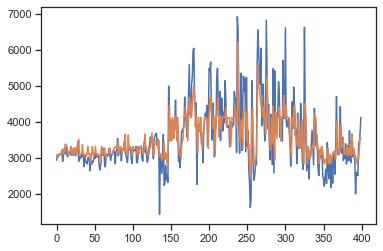

In [36]:
l = len(train_x)

x = np.arange(0, l)
y_true = []
y_pred = []

for idx in range( l ):
  # print( train_y[idx] )
  y_true.append( train_y.iloc[idx] )
y_pred = clf.predict( train_x )
  # y_true = y_true.append( train_y[idx] )
  # y_pred = y_pred.append( clf.predict( train_x[idx] ) )

fig, ax = plt.subplots()
sns.lineplot(x=x, y=y_true, ax=ax)
sns.lineplot(x=x, y=y_pred, ax=ax)

MSE: 47732.121961226105
MAE: 27.567697456998665


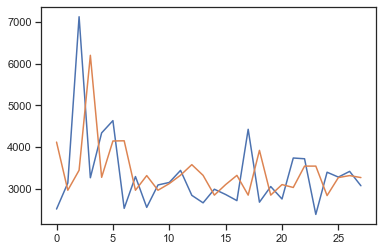

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

l = len(test_x)
x = np.arange(0, l)

y_true = []
y_pred = []

for idx in range( l ):
  # print( train_y[idx] )
  y_true.append( test_y.iloc[idx] )
  y_pred.append( clf.predict( test_x.iloc[idx].values.reshape(1, -1))[0] )
  # y_true = y_true.append( train_y[idx] )
  # y_pred = y_pred.append( clf.predict( train_x[idx] ) )

fig, ax = plt.subplots()
sns.lineplot(x=x, y=y_true, ax=ax)
sns.lineplot(x=x, y=y_pred, ax=ax)

print(f"MSE: {mean_squared_error(y_true, y_pred) / len(y_true)}") 
print(f"MAE: {mean_absolute_error(y_true, y_pred) / len(y_true)}") 